In [1]:
pip install nfl_data_py nflfastpy

     |████████████████████████████████| 51 kB 315 kB/s 
     |████████████████████████████████| 1.5 MB 20.3 MB/s 
     |████████████████████████████████| 56 kB 1.6 MB/s 
     |████████████████████████████████| 12.3 MB 20.1 MB/s 
     |████████████████████████████████| 251 kB 45.5 MB/s 
     |████████████████████████████████| 1.6 MB 38.6 MB/s 
     |████████████████████████████████| 140 kB 44.2 MB/s 
     |████████████████████████████████| 48 kB 5.1 MB/s 
     |████████████████████████████████| 45.0 MB 127 kB/s 
     |████████████████████████████████| 339 kB 46.1 MB/s 
     |████████████████████████████████| 341 kB 34.8 MB/s 
     |████████████████████████████████| 10.1 MB 25.4 MB/s 
     |████████████████████████████████| 87 kB 1.3 MB/s 
     |████████████████████████████████| 361 kB 44.7 MB/s 
  Created wheel for nfl-data-py: filename=nfl_data_py-0.2.6-py3-none-any.whl size=9741 sha256=70a0788c75766f371f24ea6b9c302b114153166d941559dcf3322ce91a31083f
  Stored in directory: /root/.cache

In [23]:
import pandas as pd
import nfl_data_py as nfl
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set_style('darkgrid')

In [24]:
df = nfl.import_pbp_data([2015,2021])

2015 done.
2021 done.
Downcasting floats.


In [26]:
receiving_df_filters = (df['pass_attempt'] == 1) & (df['two_point_attempt'] == 0)
receiving_df = df.loc[receiving_df_filters, ['pass_attempt', 'pass_touchdown', 'yardline_100']]
receiving_df_probs = receiving_df.groupby('yardline_100')['pass_touchdown'].value_counts(normalize=True)
receiving_df_probs = pd.DataFrame({
    'probability_of_touchdown': receiving_df_probs.values
}, index=receiving_df_probs.index).reset_index()
receiving_df_probs = receiving_df_probs.loc[receiving_df_probs['pass_touchdown'] == 1, ['yardline_100', 'probability_of_touchdown']]
receiving_df_probs.head()

,yardline_100,probability_of_touchdown
0,1.0,0.520737
3,2.0,0.485849
5,3.0,0.380342
7,4.0,0.386364
9,5.0,0.396364


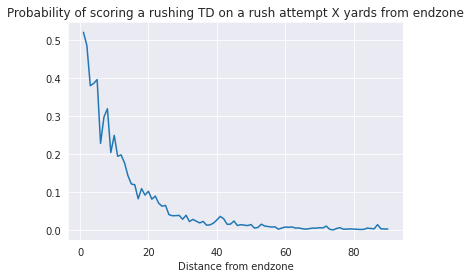

In [27]:
plt.plot(receiving_df_probs['yardline_100'], receiving_df_probs['probability_of_touchdown']);
plt.title('Probability of scoring a rushing TD on a rush attempt X yards from endzone');
plt.xlabel('Distance from endzone');

In [28]:
df_2021 = nfl.import_pbp_data([2021])

2021 done.
Downcasting floats.


In [34]:
roster_2021 = nfl.import_rosters([2022])
# receivers = roster_2021.loc[roster_2021['position'] == ['WR','TE','RB']]
# receivers.head()

In [ ]:
df_2021.info(verbose=True)

In [36]:
#
receiving_df_2021 = df_2021.loc[df_2021['pass_attempt'] == 1, 
['receiver_id', 'receiver_player_name', 'pass_attempt','pass_touchdown', 'yardline_100']]
receiving_df_2021.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21086 entries, 3 to 50709
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   receiver_id           19078 non-null  object 
 1   receiver_player_name  19077 non-null  object 
 2   pass_attempt          21086 non-null  float32
 3   pass_touchdown        21086 non-null  float32
 4   yardline_100          21086 non-null  float32
dtypes: float32(3), object(2)
memory usage: 741.3+ KB


In [37]:
receiving_df_2021 = receiving_df_2021.merge(receiving_df_probs, how='left', on='yardline_100')
receiving_df_2021 = receiving_df_2021.groupby('receiver_id', as_index=False).agg({
    'receiver_player_name': 'first', 'pass_touchdown': 'sum', 'probability_of_touchdown': 'sum'
}).rename({
    'probability_of_touchdown': 'expected_touchdowns', 'pass_touchdown': 'actual_touchdowns'
}, axis=1)
receiving_df_2021.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543 entries, 0 to 542
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   receiver_id           543 non-null    object 
 1   receiver_player_name  543 non-null    object 
 2   actual_touchdowns     543 non-null    float32
 3   expected_touchdowns   543 non-null    float64
dtypes: float32(1), float64(1), object(2)
memory usage: 15.0+ KB


In [38]:


receiving_df_2021['positive_regression_candidate'] = receiving_df_2021['actual_touchdowns'] < receiving_df_2021['expected_touchdowns']
receiving_df_2021['delta'] = receiving_df_2021.apply(lambda x: abs(x.expected_touchdowns - x.actual_touchdowns), axis=1)
receiving_df_2021.sort_values(by='expected_touchdowns', ascending=False).head()

,receiver_id,receiver_player_name,actual_touchdowns,expected_touchdowns,positive_regression_candidate,delta
218,00-0033908,C.Kupp,22.0,14.577774,False,7.422226
80,00-0031588,S.Diggs,10.0,10.109448,True,0.109448
67,00-0031381,D.Adams,11.0,9.571329,False,1.428671
321,00-0035216,D.Johnson,9.0,9.361560,True,0.361560
146,00-0033040,T.Hill,12.0,9.333953,False,2.666047


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


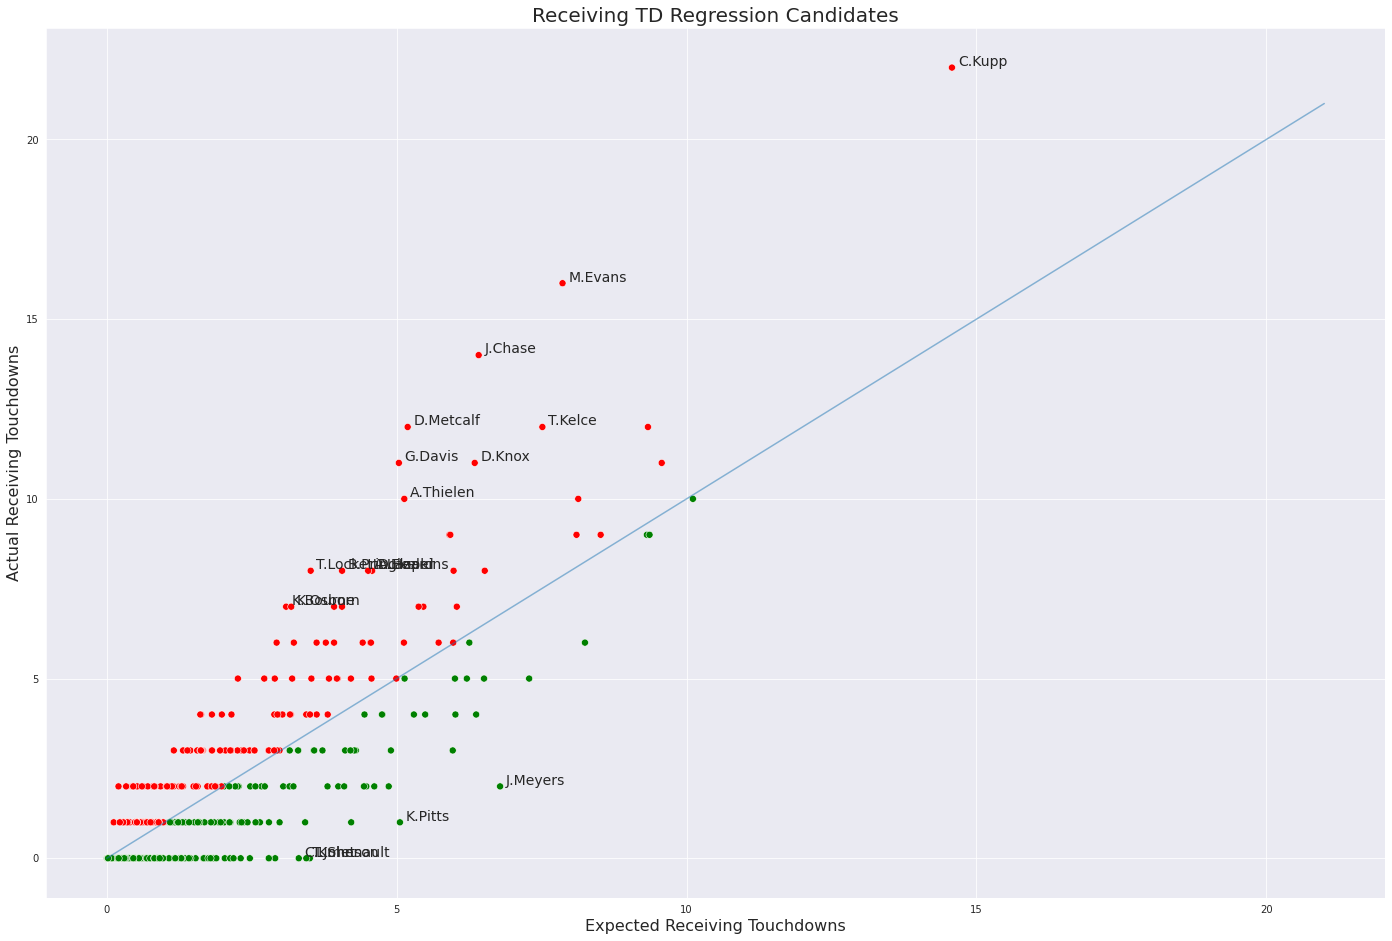

In [39]:
fig, ax = plt.subplots(figsize=(24, 16))
sns.scatterplot(
    x = 'expected_touchdowns',
    y = 'actual_touchdowns',
    hue = 'positive_regression_candidate',
    data = receiving_df_2021,
    palette = ['r', 'g'], # red and green,
    s=50
);

max_act_touchdowns = int(receiving_df_2021['actual_touchdowns'].max()) # max touchdowns
max_exp_touchdowns = int(receiving_df_2021['expected_touchdowns'].max()) # max expected touchdowns

max_tds = max(max_act_touchdowns, max_exp_touchdowns) # max of actual and expected tds

sns.lineplot(range(max_tds), range(max_tds), alpha=0.5); # plotting a line with slope of 1 up to max_tds number. This is the blue line on our viz

#15 players with the highest delta between expected and actual TDs (negative or positive)
top_x_delta = receiving_df_2021.sort_values(by='delta', ascending=False)[:20]

for _, row in top_x_delta.iterrows(): 
    ax.text(
        x = row['expected_touchdowns']+0.1, # add a bit of spacing from the point in the x-direction
        y = row['actual_touchdowns'] + .05, # same but in the y-direction
        s = row['receiver_player_name'], # annotate with the player's name,
        fontsize=14
    )
ax.get_legend().remove()
ax.set_title('Receiving TD Regression Candidates', fontsize=20)
ax.set_xlabel('Expected Receiving Touchdowns', fontsize=16)
ax.set_ylabel('Actual Receiving Touchdowns', fontsize=16);

In [40]:
top_x_delta.loc[top_x_delta['positive_regression_candidate'] == True].sort_values(by=['expected_touchdowns'], ascending=False)

,receiver_id,receiver_player_name,actual_touchdowns,expected_touchdowns,positive_regression_candidate,delta
303,00-0034960,J.Meyers,2.0,6.783143,True,4.783143
532,00-0036970,K.Pitts,1.0,5.055939,True,4.055939
435,00-0036268,L.Shenault,0.0,3.500916,True,3.500916
471,00-0036427,T.Johnson,0.0,3.441092,True,3.441092
440,00-0036290,C.Kmet,0.0,3.310750,True,3.310750


In [41]:
top_x_delta.loc[top_x_delta['positive_regression_candidate'] == False].sort_values(by=['expected_touchdowns'], ascending=False)

,receiver_id,receiver_player_name,actual_touchdowns,expected_touchdowns,positive_regression_candidate,delta
218,00-0033908,C.Kupp,22.0,14.577774,False,7.422226
71,00-0031408,M.Evans,16.0,7.860454,False,8.139546
45,00-0030506,T.Kelce,12.0,7.513148,False,4.486852
520,00-0036900,J.Chase,14.0,6.413901,False,7.586099
382,00-0035689,D.Knox,11.0,6.345431,False,4.654569
373,00-0035640,D.Metcalf,12.0,5.189263,False,6.810737
33,00-0030035,A.Thielen,10.0,5.131504,False,4.868496
418,00-0036196,G.Davis,11.0,5.037524,False,5.962476
49,00-0030564,D.Hopkins,8.0,4.578838,False,3.421162
197,00-0033699,A.Ekeler,8.0,4.574683,False,3.425317
